In [1]:
!mkdir /kaggle/working/models
!pip install GPUtil

mkdir: cannot create directory ‘/kaggle/working/models’: File exists


In [119]:
import os
import gc
import matplotlib.pyplot as plt
from GPUtil import showUtilization as gpu_usage
from collections import defaultdict
from numba import cuda

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim import lr_scheduler as schedulers
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader

cc = cuda.get_current_device().compute_capability
print("GPU compute capability: " , cc) # Should be (x,_) where x >= 7
torch.__version__ # Should be >= 2.0

GPU compute capability:  (7, 5)


In [108]:
def get_dataset(root, crop_img_size, target_img_size, split):
    transform = transforms.Compose( [
        transforms.ToTensor(), 
        transforms.CenterCrop(crop_img_size),
        transforms.Resize(target_img_size, antialias=True),
        transforms.Normalize([0.4753, 0.3938, 0.3168], [0.2981, 0.2515, 0.2818])
    ] )
    target_transform = Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    return datasets.Flowers102(root, split=split, transform=transform, target_transform=target_transform, download=True)


root = '/kaggle/working/'
crop_img_size = 450
target_img_size = 256

train_dataset = get_dataset(root, crop_img_size, target_img_size, split='train')
test_dataset  = get_dataset(root, crop_img_size, target_img_size, split='test')
eval_dataset  = get_dataset(root, crop_img_size, target_img_size, split='val')

len(train_dataset), len(test_dataset), len(eval_dataset)

(1020, 6149, 1020)

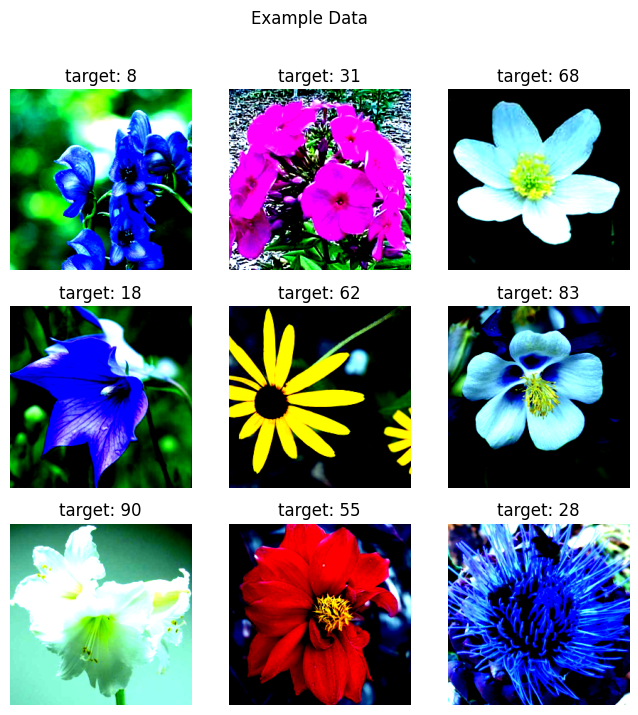

In [110]:
figure = plt.figure(figsize=(8, 8))
figure.suptitle("Example Data")
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, target = train_dataset[sample_idx]
    target = torch.nonzero(target == 1).squeeze().item()
    figure.add_subplot(rows, cols, i)
    plt.title(f'target: {target}')
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)) # tensor_image.permute(1, 2, 0)  
plt.show()

In [111]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class FlowerResNet(torch.nn.Module):
    def __init__(self, n_classes, dropout=0.2):
        super(FlowerResNet, self).__init__()
        self.n_classes = n_classes
        self.module = nn.Sequential(
            nn.Conv2d(3, 32, 7, stride=1, padding=1),
            ResNet( nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
            ) ),
            nn.Dropout(dropout),
            ResNet( nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
            ) ),
            nn.Dropout(dropout),
            nn.AdaptiveAvgPool2d(1), # Pool all the 128 filters to 1, you may need to use `torch.squeeze after this layer`
            nn.Flatten(),
            nn.Linear(32, n_classes),
        )
        
    def forward(self, inputs):
        return self.module(inputs)

In [135]:
class Record:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
    def __str__(self):
        return f'Config({str(self.__dict__)[1:-1]})'
    
    def __repr__(self):
        return self.__str__()
    
def Config(
    device='auto', lr=1e-4, epochs=10, batch_size='64', evaluate=True, evaluate_every=10, grad_norm_clip=1.0, num_workers=4, 
    optimizer=AdamW, criterion=nn.MSELoss, scheduler=None, 
    optimizer_params=None, scheduler_params=None
):
    if optimizer_params == None:
        optimizer_params = {}
    return Record(
        device=device, lr=1e-4, epochs=10, batch_size=batch_size, evaluate=evaluate, 
        evaluate_every=evaluate_every, grad_norm_clip=grad_norm_clip, num_workers=num_workers, 
        optimizer=optimizer, criterion=criterion, scheduler=scheduler, 
        optimizer_params=optimizer_params, scheduler_params=scheduler_params
    )

class Callbacks:
    def __init__(self):
        self.callbacks = defaultdict(list)
    
    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str, **kwargs):
        for callback in self.callbacks.get(onevent, []):
            callback(self, kwargs)
            
class Statistics:
    def __init__(self, model, criterion, scheduler, eval_dataset, config):
        self.train = { 'loss': 0, 'min_loss': 1e9, 'acc': 0, 'max_acc': 0 }        
        self.eval = { 'loss': 0, 'min_loss': 1e9, 'acc': 0, 'max_acc': 0 } 
        self.iter = 0
        self.model = model
        self.criterion = criterion
        self.scheduler = scheduler
        self.eval_dataset = eval_dataset
        self.config = config
        self.lr = config.lr
      
    def register_acc(self, obj, output, target):
        pred = output.argmax(dim=1, keepdim=True)
        target = target.argmax(dim=1, keepdim=True)
        correct = pred.eq(target).sum().item()
        obj['acc'] = correct * 100.0 / output.shape[0]
        obj['max_acc'] = max(self.max_train_acc, self.train_acc)
        
    def register_loss(self, obj, loss):
        obj['loss'] = obj['loss'].item()
        obj['min_loss'] = min(obj['min_loss'], obj['loss'])
    
    def register(self, train_output, train_target, train_loss):
        self.register_acc(self.train, train_output, train_target)
        self.register_loss(self.train, train_loss)

        self.lr = self.scheduler.get_lr() if self.scheduler else self.lr
        
        if self.config.evaluate and self.iter % self.config.evaluate_every == 0:
            # TODO: evaluate here
            self.register_acc(self.eval, eval_output, eval_target)
            self.register_loss(self.eval, eval_loss)
        
        self.iter += 1
        return { 'iter': self.iter, 'train': self.train, 'eval': self.eval }
            
    
class Model:
    def __init__(self, module, name):
        self.module = module        
        self.name = name
    
    @staticmethod
    def get_path(model_name, epoch):
        prefix = os.path.join("/kaggle/working/models/", model_name)
        return f'{prefix}_epoch_{epoch:03d}.pt'

    def save(self, **kwargs):
        epoch = kwargs['epoch']
        path = Model.get_path(self.name, epoch)
        print(f'\t> Saving model {self.name} at epoch {epoch} to {path}')
        torch.save(kwargs, path)

    @staticmethod
    def load(model_name, epoch):
        path = Model.get_path(model_name, epoch)
        return torch.load(path)

class Trainer(Callbacks):
    def __init__(self, model, config):
        Callbacks.__init__(self)
        
        self.config = config
        if config.device == 'auto':
            self.config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
        self.model = model.to(device=config.device)
        # self.model = torch.compile(self.model) TODO: make compile work on kaggle somehow
            
    def run(self, dataset):
        device = self.config.device
        self.model.train()
        
        optimizer = self.config.optimizer(self.model.parameters(), lr=self.config.lr, **self.config.optimizer_params)
        criterion = self.config.criterion()
        scheduler = None
        if self.config.scheduler:
            scheduler = self.config.scheduler(optimizer, **self.config.scheduler_params)
        
        train_loader = DataLoader(
            dataset,
            sampler=torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=True,
            batch_size=self.config.batch_size,
            num_workers=self.config.num_workers,
        )
        
        statistics = Statistics(self.model, criterion, scheduler, eval_dataset, self.config)

        for epoch in range(0, self.config.epochs):
            self.trigger_callbacks('on_epoch_start')
            for data, target in train_loader:
                self.trigger_callbacks('on_batch_start')
                
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                loss = criterion(output, target)
                
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.config.grad_norm_clip)
                optimizer.step()
                if scheduler:
                    scheduler.step()
                optimizer.zero_grad(set_to_none=True)
                
                train_loss = loss.item()
                stats = statistics.register(output, target, train_loss)
                self.trigger_callbacks('on_batch_end', epoch=epoch, **stats)

            self.trigger_callbacks('on_epoch_end', epoch=epoch, optimizer=optimizer, scheduler=scheduler)
        
        return statistics

In [138]:
gpu_usage()                             
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 87% |
|  1 |  0% |  8% |
| ID | GPU | MEM |
------------------
|  0 | 20% | 14% |
|  1 |  0% |  8% |


In [ ]:
def on_batch_end(_, kwargs):
    print(kwargs)
def on_epoch_end(model, kwargs):
    epoch = kwargs['epoch']
    model.save(model, epoch)
    
model = FlowerResNet(n_classes=102)
model = Model(model, 'FlowerResNet') # Model wrapper for additional functions available such as load, save, ...
config = Config(
    batch_size=128, 
    lr=2e-3, 
    criterion=nn.CrossEntropyLoss, 
    scheduler=schedulers.ExponentialLR, 
    scheduler_params={"gamma": 0.999}, 
    device='cuda:0'
)
trainer = Trainer(model, config)    
trainer.add_callback('on_batch_end', on_batch_end)
trainer.add_callback('on_epoch_end', on_epoch_end)
trainer.run(train_dataset)